In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

In [2]:
df_train = pd.read_csv('data/train.csv')

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [3]:
train_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [4]:
train, test = tml.make_test(df_train, test_size=0.25, random_state=43, strat_feat=['Pclass', 'Sex'])

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
24665,24665,0,3,"Jones, Rhett",male,44.0,0,0,25604,25.17,NaN,S
67933,67933,0,3,"Twomey, Paul",male,27.0,0,0,478284,11.53,NaN,S
41148,41148,0,3,"Brady, Amy",female,7.0,1,1,10375,80.13,NaN,S
49460,49460,0,3,"Shealy, William",male,37.0,0,0,C 15695,7.69,NaN,S
69515,69515,0,1,"Kolb, Willie",male,65.0,1,1,23480,77.39,C6991,C


In [5]:
kfolds = KFold(n_splits=10, random_state=235, shuffle=True)

num_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')), 
                     ('imp', tml.DfImputer(strategy='median'))])

cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')), 
                     ('imp', tml.DfImputer(strategy='most_frequent')), 
                     ('dum', tml.Dummify(drop_first=True))])

proc_pipe = tml.FeatureUnionDf(transformer_list=[('num', num_pipe), 
                                                 ('cat', cat_pipe)])

model = ExtraTreesClassifier(n_estimators=500, random_state=354, n_jobs=-1)

full_pipe = Pipeline([('proc', proc_pipe), ('model', model)])

In [6]:
oof = tml.cv_score(data=train[train_cols], target=train.Survived, estimator=full_pipe, cv=kfolds, predict_proba=True)

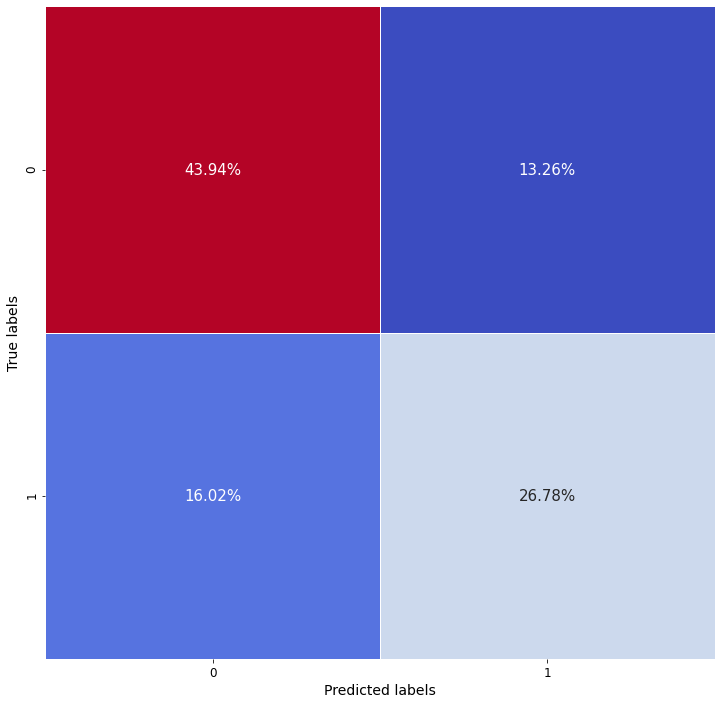

In [10]:
tml.plot_confusion_matrix(train.Survived, oof)

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


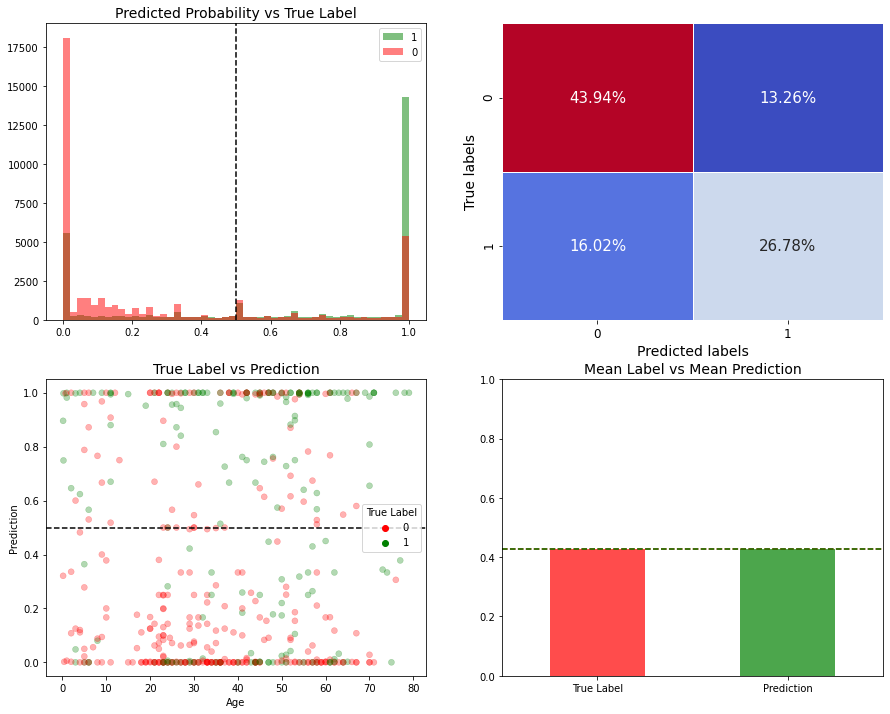

In [14]:
tml.plot_classification_probs(train, train.Survived, oof, sample=500, feat='Age')

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


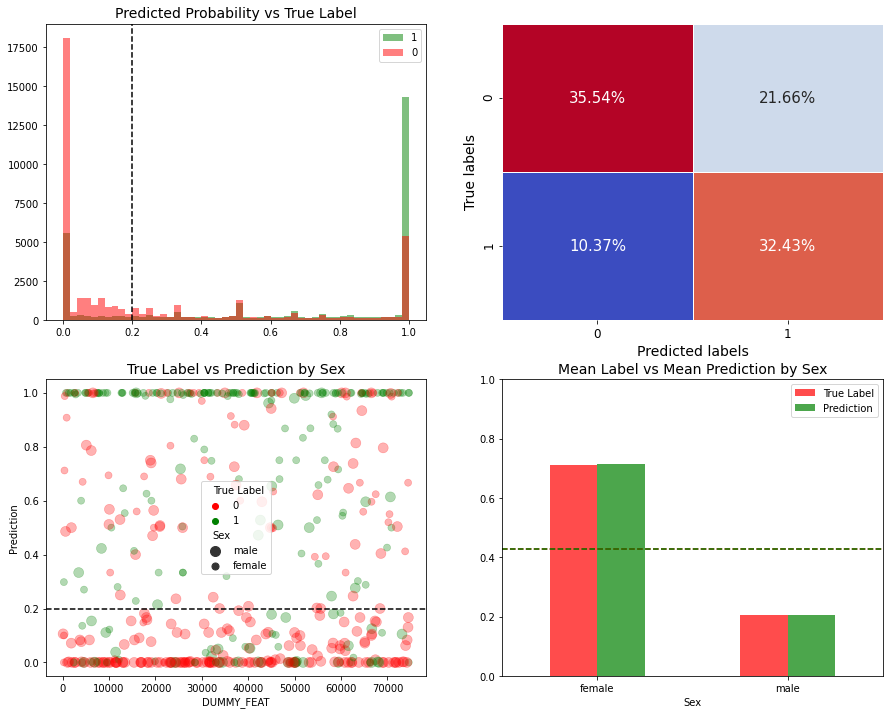

Accuracy score: 	0.6798
AUC ROC: 		0.7369
              precision    recall  f1-score   support

           0       0.77      0.62      0.69     42902
           1       0.60      0.76      0.67     32098

    accuracy                           0.68     75000
   macro avg       0.69      0.69      0.68     75000
weighted avg       0.70      0.68      0.68     75000



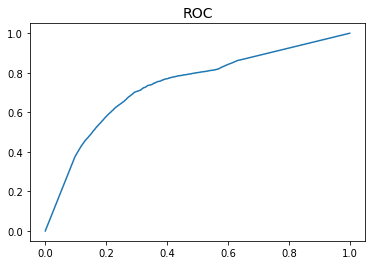

In [13]:
tml.eval_classification(train, train.Survived, oof, plot=2, proba=True, sample=500, thrs=0.2, hue_feat='Sex')